# Notebook for Project 1

_Jonatan Haraldsson_ [jonhara@chalmers.se](mailto:jonhara@chalmers.se)

_Jesper Noord_ [noord@chalmers.se](mailto:noord@chalmers.se)



In [2]:
# relevant modules for this notebook
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.gridspec import GridSpec
import emcee
import corner
import scipy
from scipy.stats import gamma, invgamma, t, norm, norminvgauss, mode, uniform
import seaborn as sns
import random
#import sklearn
import scipy.constants as const


# LaTeX font
plt.style.use('default')
plt.rc('text', usetex = True)
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
font_size = 16
plt.rcParams['font.size'] = font_size

c = const.speed_of_light *1e-3
G = const.gravitational_constant

np.random.seed(123)

**Importing the data from SCP 2.1 dataset and exploring data**

In [3]:
data_ = np.genfromtxt('SCPUnion2.1_mu_vs_z.txt')
df = pd.DataFrame(data_[:,1:5])  # only keep z, mu, mu_err
df.columns = ["z", "mu", "mu_err", "unknown"]


z = np.array(df['z'])
mu = np.array(df['mu'])
mu_err = np.array(df['mu_err'])
df.head()

,z,mu,mu_err,unknown
0,0.028488,35.346583,0.223906,0.128419
1,0.050043,36.682368,0.166829,0.128419
2,0.052926,36.817691,0.155756,0.128419
3,0.070086,37.446737,0.158467,0.128419
4,0.062668,37.483409,0.156099,0.128419


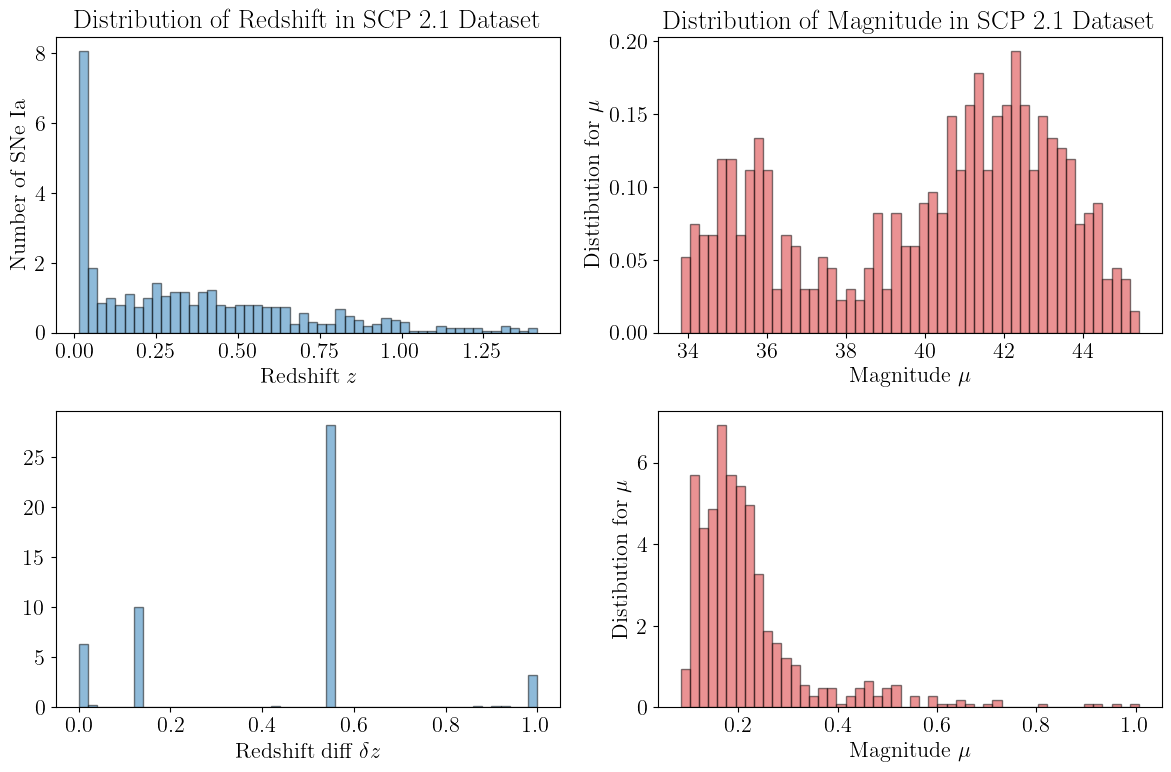

In [4]:
fig,ax = plt.subplots(2,2,figsize=(12,8))
ax[0,0].hist(z, bins=50,density=True,color='tab:blue',alpha=0.5,edgecolor='black')
ax[0,0].set_xlabel('Redshift $z$')
ax[0,0].set_ylabel('Number of SNe Ia')
ax[0,0].set_title('Distribution of Redshift in SCP 2.1 Dataset')
ax[0,1].hist(mu, bins=50,density=True,color='tab:red',alpha=0.5,edgecolor='black')
ax[0,1].set_xlabel('Magnitude $\\mu$')
ax[0,1].set_ylabel('Disttibution for $\\mu$')
ax[0,1].set_title('Distribution of Magnitude in SCP 2.1 Dataset')
ax[0,1].set_xlabel('Magnitude $\\mu$')
ax[0,1].set_ylabel('Disttibution for $\\mu$')
ax[0,1].set_title('Distribution of Magnitude in SCP 2.1 Dataset')


ax[1,0].hist(df['unknown'], bins=50,density=True,color='tab:blue',alpha=0.5,edgecolor='black')
ax[1,0].set_xlabel('Redshift diff $\\delta z$')
#ax[0,0].set_ylabel('Number of SNe Ia')
#ax[0,0].set_title('Distribution of Redshift in SCP 2.1 Dataset')
ax[1,1].hist(mu_err, bins=50,density=True,color='tab:red',alpha=0.5,edgecolor='black')
ax[1,1].set_xlabel('Magnitude $\\mu$')
ax[1,1].set_ylabel('Distibution for $\\mu$')
ax[1,1].set_xlabel('Magnitude $\\mu$')
ax[1,1].set_ylabel('Distibution for $\\mu$')

plt.tight_layout()
plt.show()

### Defining some useful functions  

In [5]:
def mu_to_d(mu):
    return 10**((mu - 25) / 5)  # in Mpc

def d_to_mu(d):
    if all(i <= 0  for i in d) == False:
        mu = 5 * np.log10(d) + 25
    else:
        print(f'MIN DISTANCE: {np.min(d)}')
        raise ValueError("Distance must be positive.")
    return mu

def rho_crit(H):
    return 3 * H**2 / (8 * np.pi * G)

def get_Om_lam(lam,H):
    return lam / (3 * H**2)

def get_Om_M(lam,H,Om_k = None):
    if Om_k is not None:
        return 1 - Om_k - get_Om_lam(lam,H)
    else:
        return 1 - get_Om_lam(lam,H)
    
def get_q0(Om_M,Om_lam):
    return Om_M / 2 - Om_lam


def E(theta, z):
    try:
        Om_lam = theta[0]
        w = theta[1]
    except:
        Om_lam = theta
        w = -1

    Om_M = 1 - Om_lam  # assuming flat universe Om_k=0
    
    return Om_M *(1 + z)**3 + Om_lam * (1 + z)**(3 * (1 + w))


def model(theta, z, H0 = 70):
    d = np.zeros_like(z)
    for i, z_i in enumerate(z):
        z_p = np.linspace(0, z_i, 50)
        d[i] = c * (1 + z_i) * np.trapezoid(y=1/ (H0 * np.sqrt(E(theta, z_p))), x=z_p)

    mu = d_to_mu(d)
    return mu

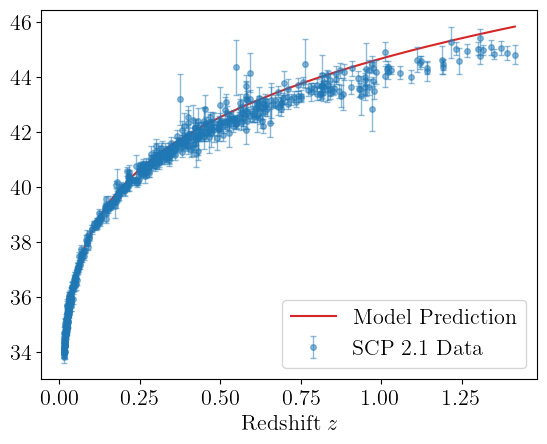

In [6]:
theta0 = [1, -1]
theta0 = 1
plt.plot(np.sort(z), model(theta0, np.sort(z)), color='tab:red', label='Model Prediction')
plt.errorbar(z, df['mu'], yerr=mu_err, fmt='o', markersize=4, elinewidth=1, capsize=2, alpha=0.5, label='SCP 2.1 Data', color='tab:blue')
plt.xlabel('Redshift $z$');
plt.legend()

In [7]:
def log_likelihood(theta, z, mu, sig_mu):
       Nd = len(mu)
       resid = mu - model(theta, z)
       W = 1.0 / (sig_mu**2)
       quad = -1/2 * np.sum(resid**2 * W)
       const = -Nd/2 * np.log(2 * np.pi) + 1/2 * np.sum(np.log(W))
       return quad + const

From likelihood
$$
p(\mathcal{D} \mid \theta)
= (2\pi)^{-N_d/2}|W|^{1/2}
\exp\!\Big[-\tfrac{1}{2}(\mathcal{D}-\Phi\theta)^T W(\mathcal{D}-\Phi\theta)\Big]
$$

$$
\begin{aligned}
\log \mathcal{L}(\theta, z, \mu, \sigma_\mu)
&= -\tfrac{1}{2} \Big[ (\mu - \text{model}(\theta, z))^{T} 
\; W \; (\mu - \text{model}(\theta, z)) 
+ N_d \log(2\pi) - \sum_i \log(\sigma_{\mu,i}^2) \Big] \\
\text{where} \quad 
W &= \mathrm{diag}\left( \frac{1}{\sigma_\mu^2} \right)
\end{aligned}
$$

In [8]:
def ml_param(theta0, z=df['z'], mu=df['mu'], dmu=df['mu_err']):
    res = scipy.optimize.minimize(lambda th: -log_likelihood(th, z, mu, dmu), theta0)
    theta_opt = res.x
    return theta_opt

def bic(theta, z, mu, mu_err):
    Np = len(theta)
    Nd = len(mu)
    return 2 * log_likelihood(theta, z, mu, mu_err) - Np * np.log(Nd)

def aic(theta, z, mu, mu_err):
    Np = len(theta)
    return 2 * log_likelihood(theta, z, mu, mu_err) - 2 * Np

In [9]:
theta0 = [1, -1]
like = log_likelihood(theta0, z, df['mu'], mu_err)

print(model(theta0, z[0:1]))
print('Likelihood:', like)

th_opt_lam = ml_param(theta0=[1, -1])
th_opt_w = ml_param(theta0=1)

print('theta opt lam:', th_opt_lam)
print('theta opt w:', th_opt_w)

[35.49291926]
Likelihood: -253.2679358720991
theta opt lam: [ 0.72034163 -1.00453224]
theta opt w: [0.72228424]


In [10]:
grid = 25
Om_lam_grid = np.linspace(0.5,1,grid)
w_grid = np.linspace(0,-1.5,grid)

Om_lam_g, w_g = np.meshgrid(Om_lam_grid,w_grid)

z = z
mu = df['mu']
sig = df['mu_err']


n = 0
like = np.zeros((len(w_grid),len(Om_lam_grid)))
sum_like = 0
for w_i,i in zip(w_grid, range(len(w_grid))):
    for Om_lam_i,j in zip(Om_lam_grid, range(len(Om_lam_grid))):
        lh = log_likelihood([Om_lam_i,w_i], z, mu, sig)
        like[i,j] = np.exp(lh)

        # if n % 100 == 0:
        #     print(f'n={n/grid**2*100}%')
        # n+=1



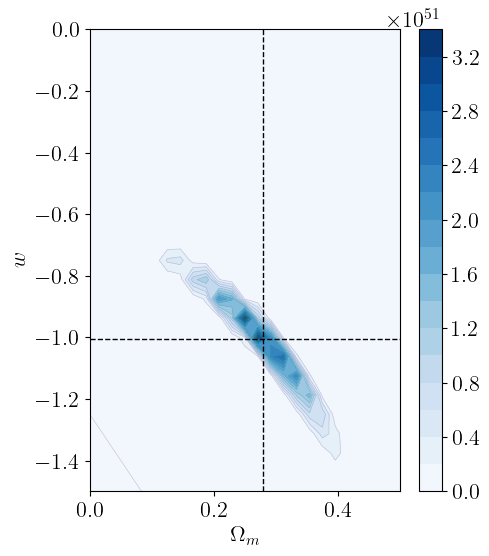

In [17]:
plt.figure(figsize=(5,6));
plt.contour(1-Om_lam_g, w_g, like, levels=20, alpha=0.2, linewidths=0.5);
plt.contourf(1-Om_lam_g, w_g, like, levels=20, cmap='Blues');
plt.colorbar();
plt.vlines(1-th_opt_lam[0], ymin=np.min(w_g), ymax=np.max(w_g), colors='black', linestyles='dashed', label='MLE', linewidth=1);
plt.hlines(th_opt_lam[1], xmin=0, xmax=0.5, colors='black', linestyles='dashed', linewidth=1);
plt.xlabel(r'$\Omega_m$');
plt.ylabel('$w$');

387
0.75 -0.9375
0.0


/Users/noord/myenv/lib/python3.13/site-packages/seaborn/axisgrid.py:1883: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(x=self.x, ax=self.ax_marg_x, **kwargs)
/Users/noord/myenv/lib/python3.13/site-packages/seaborn/axisgrid.py:1889: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(y=self.y, ax=self.ax_marg_y, **kwargs)


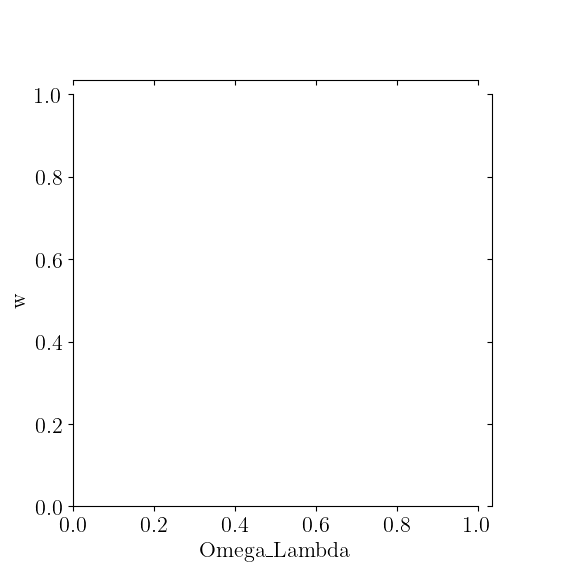

In [15]:
P = like.copy()                     # your 2D likelihood grid
P = np.exp(P - np.max(P))           # if it's in log form
P /= np.sum(P)                      # normalize to make it sum to 1

p_flat = P.flatten()
Om_flat = Om_lam_g.flatten()
w_flat = w_g.flatten()

N_samples = 10000
rng = np.random.default_rng(42)
indices = rng.choice(len(p_flat), size=N_samples, p=p_flat)
Om_samples = Om_flat[indices]
w_samples  = w_flat[indices]

df = pd.DataFrame({'Omega_Lambda': Om_samples, 'w': w_samples})

print(np.argmax(p_flat))
print(Om_flat[np.argmax(p_flat)], w_flat[np.argmax(p_flat)])
print(np.max(Om_samples-np.max(Om_samples)))

sns.jointplot(data=df, x='Omega_Lambda', y='w', kind='kde', fill=True, cmap='viridis')

In [ ]:
sns.jointplot(data=samples, x=0, y=1, kind="kde", fill=True, cmap="Blues", height=7)

In [ ]:
th_opt_lam = ml_param(theta0=[1, -1])
print('--- LambdaCDM ---')
print(f'BIC: {bic(th_opt_lam, z, mu, mu_err)}')
print(f'AIC: {aic(th_opt_lam, z, mu, mu_err)}')

th_opt_w = ml_param(theta0=1)
print('--- wCDM---')
print(f'BIC: {bic([th_opt_w[0], -1], z, mu, mu_err)}')
print(f'AIC: {aic([th_opt_w[0], -1], z, mu, mu_err)}')

NameError: name 'ml_param' is not defined

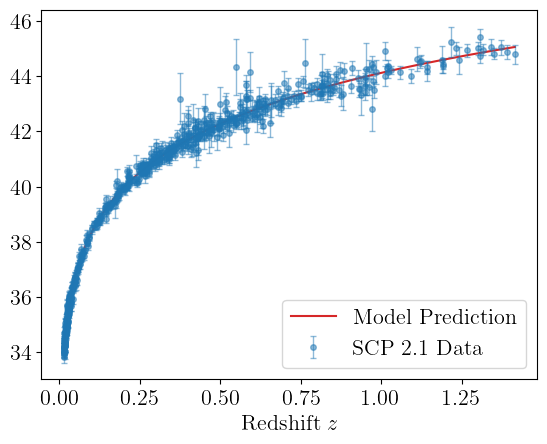

In [ ]:
plt.plot(np.sort(z), model(th_opt_lam, np.sort(z)), color='tab:red', label='Model Prediction')
plt.errorbar(z, df['mu'], yerr=mu_err, fmt='o', markersize=4, elinewidth=1, capsize=2, alpha=0.5, label='SCP 2.1 Data', color='tab:blue')
plt.xlabel('Redshift $z$');
plt.legend()